# Import Library

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os 
import sklearn
from sklearn.utils import class_weight
import tensorflow as tf

import warnings
warnings.simplefilter("ignore")
%matplotlib inline

In [2]:
DIR_DATA_PATH = os.path.join("..", "artifacts", "raw")

## Read Recommendation.csv

In [3]:
recommendation_df = pd.read_csv(DIR_DATA_PATH+"/recommendations.csv", low_memory=True, usecols=["app_id", "user_id", "is_recommended"])
recommendation_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41154794 entries, 0 to 41154793
Data columns (total 3 columns):
 #   Column          Dtype
---  ------          -----
 0   app_id          int64
 1   is_recommended  bool 
 2   user_id         int64
dtypes: bool(1), int64(2)
memory usage: 667.2 MB


In [4]:
recommendation_df.head()

,app_id,is_recommended,user_id
0,975370,True,51580
1,304390,False,2586
2,1085660,True,253880
3,703080,True,259432
4,526870,True,23869


In [5]:
recommendation_df.duplicated().sum()

np.int64(16)

Delete data duplicated and keep the last 

In [6]:
recommendation_df.loc[recommendation_df.duplicated()]

,app_id,is_recommended,user_id
5521962,1142710,True,11640276
12060729,451020,True,4225445
15098471,1293830,True,3280730
17705203,1145360,True,11571854
18592841,1063730,False,3148709
19691801,945360,True,10858200
20332724,617290,True,3081752
22874764,570940,True,14227998
23765890,1454400,True,3054178
24887439,440,True,2433696


In [7]:
recommendation_df.drop_duplicates(subset=["app_id", "user_id"], keep="last", inplace=True)
len(recommendation_df)

41154773

In [8]:
recommendation_df.isnull().sum()

app_id            0
is_recommended    0
user_id           0
dtype: int64

There is no NaN value, it's because the dataset has processed from kaggle

In [9]:
user_counts = recommendation_df["user_id"].value_counts()
recommendation_df["user_count"] = recommendation_df["user_id"].map(user_counts)
recommendation_df.head()

,app_id,is_recommended,user_id,user_count
0,975370,True,51580,5
1,304390,False,2586,1
2,1085660,True,253880,2
3,703080,True,259432,2
4,526870,True,23869,2


In [10]:
len(recommendation_df.loc[recommendation_df["user_count"]>=100])

1539389

In [11]:
# just use data user_id that has doen review many game 100
recommendation_df = recommendation_df.loc[recommendation_df["user_count"]>=100]
len(recommendation_df)

1539389

In [12]:
print(f'Total of user that has given review : {recommendation_df["user_id"].nunique()}')
print(f'Total of game that is given review by user : {recommendation_df["app_id"].nunique()}')

Total of user that has given review : 8364
Total of game that is given review by user : 35032


In [13]:
# change column is_recommended 1 for true and 0 for false
recommendation_df["is_recommended"] = recommendation_df['is_recommended'].apply(lambda x: 1 if x == True else 0)
recommendation_df["is_recommended"].value_counts()

is_recommended
1    1200530
0     338859
Name: count, dtype: int64

Let's set weight for each class in target so that our base model (Neural Network) can predict more optimal

In [14]:
# make encode and decode for user id
list_users = recommendation_df["user_id"].unique().tolist()
user_encoded = {x : i for i, x in enumerate(list_users)}
user_decoded = {i : x for i, x in enumerate(list_users)}
recommendation_df["user"] = recommendation_df["user_id"].map(user_encoded)
len(user_decoded)


8364

In [15]:
user_encoded

{5935019: 0,
 6334645: 1,
 6484333: 2,
 10383001: 3,
 11659871: 4,
 8691685: 5,
 13480445: 6,
 1281900: 7,
 11345559: 8,
 11589506: 9,
 1359770: 10,
 8471103: 11,
 13517675: 12,
 11548912: 13,
 7496905: 14,
 11485834: 15,
 11593837: 16,
 2656542: 17,
 804746: 18,
 7964123: 19,
 12499337: 20,
 3537883: 21,
 5147204: 22,
 740886: 23,
 4180816: 24,
 4374169: 25,
 5904112: 26,
 11247431: 27,
 13934014: 28,
 11954936: 29,
 2642833: 30,
 10159024: 31,
 8431309: 32,
 5847936: 33,
 7620549: 34,
 13520295: 35,
 13099571: 36,
 5049902: 37,
 5003446: 38,
 8086076: 39,
 490548: 40,
 4573383: 41,
 11777352: 42,
 3630187: 43,
 13278270: 44,
 6183594: 45,
 779260: 46,
 6217328: 47,
 4680517: 48,
 5228258: 49,
 4240625: 50,
 6240208: 51,
 4381010: 52,
 2522885: 53,
 5606871: 54,
 8062005: 55,
 7661774: 56,
 7915225: 57,
 10546013: 58,
 14299904: 59,
 14237969: 60,
 11076296: 61,
 6773254: 62,
 7243163: 63,
 11117352: 64,
 2823542: 65,
 12079839: 66,
 9548454: 67,
 11490641: 68,
 11114405: 69,
 1186596

In [16]:
user_decoded

{0: 5935019,
 1: 6334645,
 2: 6484333,
 3: 10383001,
 4: 11659871,
 5: 8691685,
 6: 13480445,
 7: 1281900,
 8: 11345559,
 9: 11589506,
 10: 1359770,
 11: 8471103,
 12: 13517675,
 13: 11548912,
 14: 7496905,
 15: 11485834,
 16: 11593837,
 17: 2656542,
 18: 804746,
 19: 7964123,
 20: 12499337,
 21: 3537883,
 22: 5147204,
 23: 740886,
 24: 4180816,
 25: 4374169,
 26: 5904112,
 27: 11247431,
 28: 13934014,
 29: 11954936,
 30: 2642833,
 31: 10159024,
 32: 8431309,
 33: 5847936,
 34: 7620549,
 35: 13520295,
 36: 13099571,
 37: 5049902,
 38: 5003446,
 39: 8086076,
 40: 490548,
 41: 4573383,
 42: 11777352,
 43: 3630187,
 44: 13278270,
 45: 6183594,
 46: 779260,
 47: 6217328,
 48: 4680517,
 49: 5228258,
 50: 4240625,
 51: 6240208,
 52: 4381010,
 53: 2522885,
 54: 5606871,
 55: 8062005,
 56: 7661774,
 57: 7915225,
 58: 10546013,
 59: 14299904,
 60: 14237969,
 61: 11076296,
 62: 6773254,
 63: 7243163,
 64: 11117352,
 65: 2823542,
 66: 12079839,
 67: 9548454,
 68: 11490641,
 69: 11114405,
 70: 118

In [17]:
# Make encode and decode for app_id 
list_apps = recommendation_df['app_id'].unique().tolist()
app_encode = {x : i for i, x in enumerate(list_apps)}
app_decode = {i : x for i, x in enumerate(list_apps)}
recommendation_df['app'] = recommendation_df['app_id'].map(app_encode)
len(list_apps)

35032

In [18]:
n_games = len(app_encode)
n_users = len(user_encoded)
print(f"Numbers of games {n_games} and users {n_users}")

Numbers of games 35032 and users 8364


In [19]:
# shuffle recommendation_df
recommendation_df = recommendation_df.sample(frac=1, random_state=42).reset_index()

In [20]:
# Split recommendation_df to X and y
X = recommendation_df[["user", "app"]].values
y = recommendation_df["is_recommended"]

In [21]:
X

array([[ 4902,   237],
       [ 5674,  1112],
       [ 6965,   610],
       ...,
       [ 2834,  1997],
       [ 4934, 15467],
       [ 3145,  1141]])

In [22]:
y

0          0
1          0
2          1
3          0
4          1
          ..
1539384    1
1539385    1
1539386    1
1539387    1
1539388    1
Name: is_recommended, Length: 1539389, dtype: int64

In [23]:
test_size = 1000
train_size = recommendation_df.shape[0] - test_size
print(f"Amount of data train {train_size} and data test {test_size}")

Amount of data train 1538389 and data test 1000


In [24]:
X_train, X_test, y_train, y_test = (
    X[:train_size],
    X[train_size:],
    y[:train_size],
    y[train_size:]
)

In [25]:
X_train_array = [X_train[: , 0] , X_train[: ,1]]
X_test_array = [X_test[: , 0] , X_test[: ,1]]

In [26]:
print(X_train_array) 

[array([4902, 5674, 6965, ..., 7127, 6091, 4300]), array([  237,  1112,   610, ...,  6005, 20512,  5020])]


In [27]:
# Let's define weight for each class in our target
class_weights = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train

)

class_weights_dict = dict(zip(np.unique(y_train), class_weights))
class_weights_dict

{np.int64(0): np.float64(2.2714627001423366),
 np.int64(1): np.float64(0.6411263132889632)}

weight of class 0 (not recommended) is higher than weight of class 1 (recommended) that because numbers of class 1 more than class 0. so model must carefully to predict class 0

In [28]:
recommendation_df.head()

,index,app_id,is_recommended,user_id,user_count,user,app
0,20033838,460930,0,2046877,538,4902,237
1,27697512,683320,0,2009370,208,5674,1112
2,20724916,337000,1,9279272,112,6965,610
3,31621505,268050,0,8463010,138,5509,22514
4,28002470,575860,1,8388456,236,7054,7432


## BASE MODEL

In [29]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation, BatchNormalization, Input, Embedding, Dot, Dense, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras import backend as K


In [30]:
## Create custom function to recall, precision, and f1-score 
def recall_score(y_true, y_pred):
    y_true = K.cast(y_true, tf.float32)
    y_pred = K.cast(y_pred, tf.float32)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_score(y_true, y_pred):
    y_true = K.cast(y_true, tf.float32)
    y_pred = K.cast(y_pred, tf.float32)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1(y_true, y_pred):
    y_true = K.cast(y_true, tf.float32)
    y_pred = K.cast(y_pred, tf.float32)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [31]:
def RecomendationNN():
    embedded_size = 128

    # User Input and Embedding
    user = Input(name="user_input", shape=[1])
    user_embedding = Embedding(name="user_embedding", input_dim=n_users, output_dim=embedded_size)(user)

    # Game_id Input and Embedding
    game = Input(name="game_input", shape=[1])
    game_embedding = Embedding(name="game_embedding", input_dim=n_games, output_dim=embedded_size)(game)

    # Dot and Flatten
    X = Dot(name="dot_product", axes=2, normalize=True)([user_embedding, game_embedding]) 
    X = Flatten()(X)

    # NN
    X = Dense(1, kernel_initializer="he_normal")(X)
    X = BatchNormalization()(X)
    X = Activation("sigmoid")(X)


    model = Model(inputs=[user, game], outputs=X)
    model.compile(loss="binary_crossentropy",metrics=["accuracy", f1, precision_score, recall_score],optimizer='Adam')

    return model


In [32]:
model = RecomendationNN()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ game_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 128)    │  1,070,592 │ user_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ game_embedding      │ (None, 1, 128)    │  4,484,096 │ game_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_product (Dot)   │ (None, 1, 1)      │          0 │ user_embedding[0… │
│                     │                   │            │ game_embedding[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1)         │          0 │ dot_product[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │          2 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1)         │          4 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1)         │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,554,694 (21.19 MB)

 Trainable params: 5,554,692 (21.19 MB)

 Non-trainable params: 2 (8.00 B)

In [33]:
# Function for search LR
start_lr = 0.00001
min_lr = 0.0001
max_lr = 0.00005
batch_size = 10000

ramup_epochs = 5
sustain_epochs = 0
exp_decay = 0.8

def lrfn(epoch):
    if epoch<ramup_epochs:
        return (max_lr-start_lr)/ramup_epochs*epoch + start_lr
    elif epoch<ramup_epochs+sustain_epochs:
        return max_lr
    else:
        return (max_lr-min_lr) * exp_decay ** (epoch-ramup_epochs-sustain_epochs)+min_lr

In [34]:
# Define Callbaks
lr_callback = LearningRateScheduler(lambda epoch : lrfn(epoch), verbose=1)

checkpoint_file_path = "./weights.weights.h5"
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_file_path, monitor="val_loss", mode="min", save_weights_only=True, save_best_only=True)

stop_callback = EarlyStopping(patience=3,monitor="val_loss",mode="min",restore_best_weights=True)

callbacks_list = [lr_callback, stop_callback, checkpoint_callback]

In [35]:
# Train model
history = model.fit(
    x=X_train_array,
    y=y_train,
    batch_size=batch_size, 
    epochs=32,
    verbose=1,
    validation_data=(X_test_array,y_test),
    class_weight=class_weights_dict,
    callbacks=callbacks_list

)


Epoch 1: LearningRateScheduler setting learning rate to 1e-05.
Epoch 1/32
154/154 ━━━━━━━━━━━━━━━━━━━━ 21s 108ms/step - accuracy: 0.5001 - f1: 0.6096 - loss: 0.7855 - precision_score: 0.7800 - recall_score: 0.5003 - val_accuracy: 0.5140 - val_f1: 0.6301 - val_loss: 0.6939 - val_precision_score: 0.7681 - val_recall_score: 0.5342 - learning_rate: 1.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1.8000000000000004e-05.
Epoch 2/32
154/154 ━━━━━━━━━━━━━━━━━━━━ 15s 98ms/step - accuracy: 0.5035 - f1: 0.6122 - loss: 0.7795 - precision_score: 0.7833 - recall_score: 0.5024 - val_accuracy: 0.5100 - val_f1: 0.6265 - val_loss: 0.6998 - val_precision_score: 0.7654 - val_recall_score: 0.5303 - learning_rate: 1.8000e-05

Epoch 3: LearningRateScheduler setting learning rate to 2.6000000000000002e-05.
Epoch 3/32
154/154 ━━━━━━━━━━━━━━━━━━━━ 14s 91ms/step - accuracy: 0.5084 - f1: 0.6159 - loss: 0.7712 - precision_score: 0.7877 - recall_score: 0.5056 - val_accuracy: 0.5120 - val_f1: 0.

In [36]:
history_df = pd.DataFrame(history.history)
history_df.head()

,accuracy,f1,loss,precision_score,recall_score,val_accuracy,val_f1,val_loss,val_precision_score,val_recall_score,learning_rate
0,0.500327,0.609706,0.785356,0.779991,0.500460,0.514,0.630137,0.693911,0.768089,0.534194,0.000010
1,0.503294,0.612053,0.780111,0.782884,0.502433,0.510,0.626524,0.699782,0.765363,0.530323,0.000018
2,0.508516,0.616265,0.771252,0.787845,0.506067,0.512,0.628049,0.719505,0.767225,0.531613,0.000026
3,0.516354,0.622720,0.758794,0.794989,0.511827,0.509,0.625477,0.748835,0.764925,0.529032,0.000034


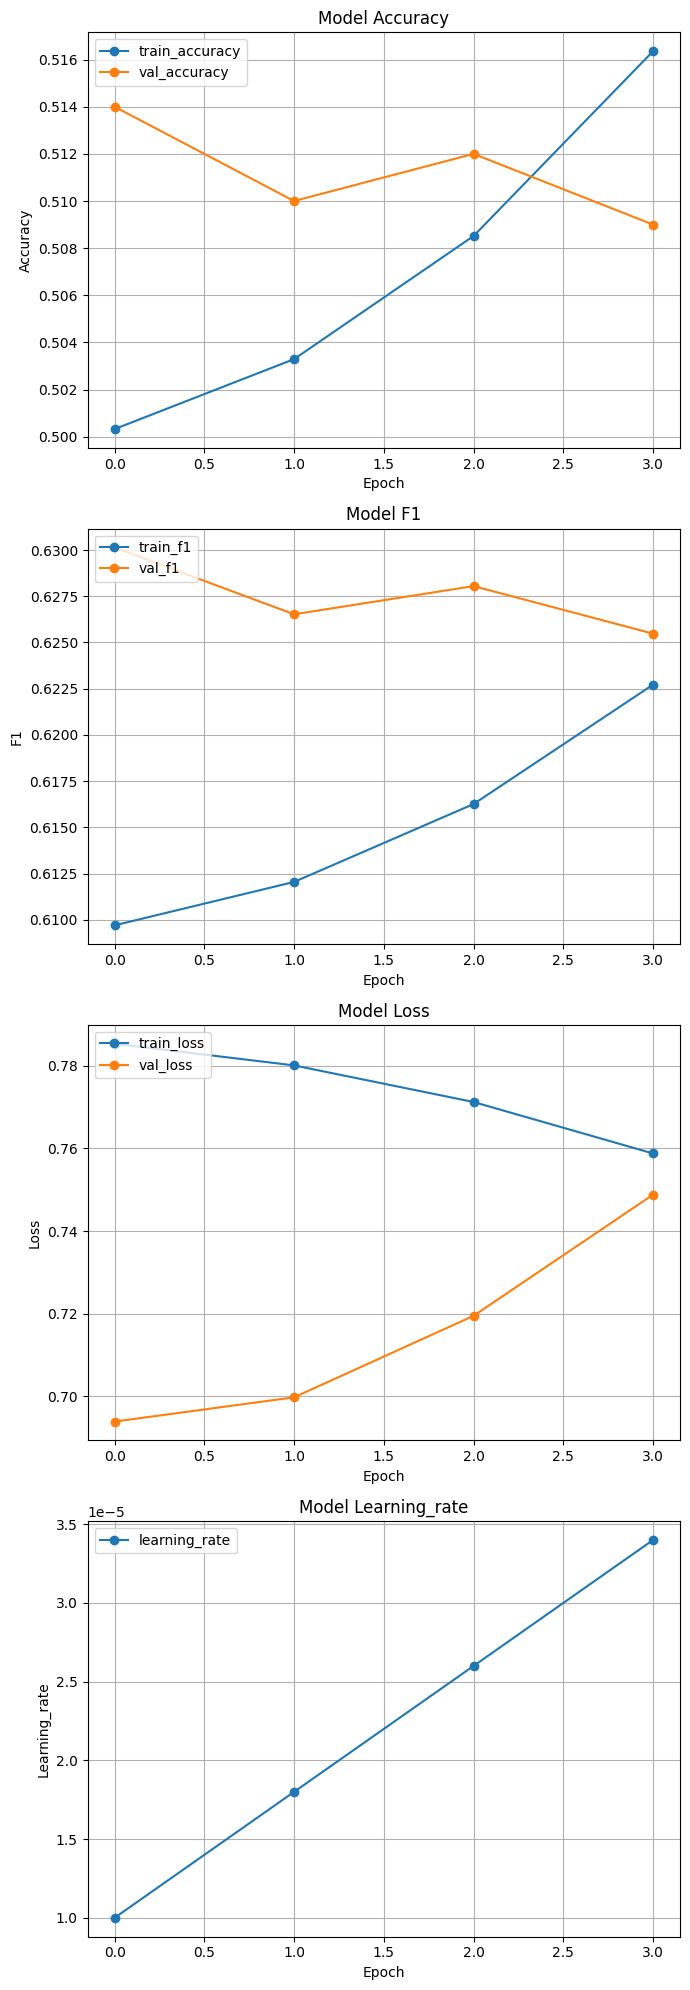

In [37]:
metrics = ["accuracy", "f1", "loss", "learning_rate"]

fig, axes = plt.subplots(len(metrics), 1, figsize=(7, len(metrics)*5))

for i, metric in enumerate(metrics):
    if i == 3:
        ax = axes[i]
        ax.plot(history.history[metric], marker="o", label=f"{metric}")
        ax.set_title(f"Model {metric.capitalize()}")
        ax.set_ylabel(metric.capitalize())
        ax.set_xlabel("Epoch")
        ax.legend(loc="upper left")
        ax.grid(True)
    else:    
        ax = axes[i]
        ax.plot(history.history[metric], marker="o", label=f"train_{metric}")
        ax.plot(history.history[f"val_{metric}"], marker="o", label=f"val_{metric}") 
        ax.set_title(f"Model {metric.capitalize()}")
        ax.set_ylabel(metric.capitalize())
        ax.set_xlabel("Epoch")
        ax.legend(loc="upper left")
        ax.grid(True)

plt.tight_layout()
plt.show()

In [38]:
def extract_weight(layer_name, model):
    layer_weight = model.get_layer(layer_name)
    weight = layer_weight.get_weights()[0]
    weight = weight/np.linalg.norm(weight, axis=1).reshape((-1,1))
    return weight


In [39]:
user_weight = extract_weight("user_embedding", model)
game_weight = extract_weight("game_embedding", model)

## Read Game.csv

In [40]:
game_df = pd.read_csv(f"{DIR_DATA_PATH}/games.csv", low_memory=True)
game_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50872 entries, 0 to 50871
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   app_id          50872 non-null  int64  
 1   title           50872 non-null  object 
 2   date_release    50872 non-null  object 
 3   win             50872 non-null  bool   
 4   mac             50872 non-null  bool   
 5   linux           50872 non-null  bool   
 6   rating          50872 non-null  object 
 7   positive_ratio  50872 non-null  int64  
 8   user_reviews    50872 non-null  int64  
 9   price_final     50872 non-null  float64
 10  price_original  50872 non-null  float64
 11  discount        50872 non-null  float64
 12  steam_deck      50872 non-null  bool   
dtypes: bool(4), float64(3), int64(3), object(3)
memory usage: 3.7+ MB


In [41]:
game_df.head()

,app_id,title,date_release,win,mac,linux,rating,positive_ratio,user_reviews,price_final,price_original,discount,steam_deck
0,13500,Prince of Persia: Warrior Within™,2008-11-21,True,False,False,Very Positive,84,2199,9.99,9.99,0.0,True
1,22364,BRINK: Agents of Change,2011-08-03,True,False,False,Positive,85,21,2.99,2.99,0.0,True
2,113020,Monaco: What's Yours Is Mine,2013-04-24,True,True,True,Very Positive,92,3722,14.99,14.99,0.0,True
3,226560,Escape Dead Island,2014-11-18,True,False,False,Mixed,61,873,14.99,14.99,0.0,True
4,249050,Dungeon of the ENDLESS™,2014-10-27,True,True,False,Very Positive,88,8784,11.99,11.99,0.0,True


In [42]:
game_df["rating"].value_counts()

rating
Positive                   13502
Very Positive              13139
Mixed                      12157
Mostly Positive             8738
Mostly Negative             1849
Overwhelmingly Positive     1110
Negative                     303
Very Negative                 60
Overwhelmingly Negative       14
Name: count, dtype: int64

In [43]:
game_df.describe()

,app_id,positive_ratio,user_reviews,price_final,price_original,discount
count,5.087200e+04,50872.000000,5.087200e+04,50872.000000,50872.000000,50872.000000
mean,1.055224e+06,77.052033,1.824425e+03,8.620325,8.726788,5.592212
std,6.103249e+05,18.253592,4.007352e+04,11.514164,11.507021,18.606679
min,1.000000e+01,0.000000,1.000000e+01,0.000000,0.000000,0.000000
25%,5.287375e+05,67.000000,1.900000e+01,0.990000,0.990000,0.000000
50%,9.860850e+05,81.000000,4.900000e+01,4.990000,4.990000,0.000000
75%,1.524895e+06,91.000000,2.060000e+02,10.990000,11.990000,0.000000
max,2.599300e+06,100.000000,7.494460e+06,299.990000,299.990000,90.000000


In [44]:
game_df.isnull().sum()

app_id            0
title             0
date_release      0
win               0
mac               0
linux             0
rating            0
positive_ratio    0
user_reviews      0
price_final       0
price_original    0
discount          0
steam_deck        0
dtype: int64

In [45]:
def SupportDevice(cols, df):
    devices = []
    for idx, row in df.iterrows():
        device = ", ".join([col for col in cols if row[col] == True])
        devices.append(device)
    df["support_devices"] = devices

    return df
   

In [46]:
cols = ['win', 'mac', 'linux']
game_df = SupportDevice(cols, game_df)
game_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50872 entries, 0 to 50871
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   app_id           50872 non-null  int64  
 1   title            50872 non-null  object 
 2   date_release     50872 non-null  object 
 3   win              50872 non-null  bool   
 4   mac              50872 non-null  bool   
 5   linux            50872 non-null  bool   
 6   rating           50872 non-null  object 
 7   positive_ratio   50872 non-null  int64  
 8   user_reviews     50872 non-null  int64  
 9   price_final      50872 non-null  float64
 10  price_original   50872 non-null  float64
 11  discount         50872 non-null  float64
 12  steam_deck       50872 non-null  bool   
 13  support_devices  50872 non-null  object 
dtypes: bool(4), float64(3), int64(3), object(4)
memory usage: 4.1+ MB


In [47]:
game_df.columns

Index(['app_id', 'title', 'date_release', 'win', 'mac', 'linux', 'rating',
       'positive_ratio', 'user_reviews', 'price_final', 'price_original',
       'discount', 'steam_deck', 'support_devices'],
      dtype='object')

In [48]:
game_df = game_df[['app_id', 'title', 'date_release', 'support_devices', 'user_reviews', 'rating', 'price_final']]
game_df.head()

,app_id,title,date_release,support_devices,user_reviews,rating,price_final
0,13500,Prince of Persia: Warrior Within™,2008-11-21,win,2199,Very Positive,9.99
1,22364,BRINK: Agents of Change,2011-08-03,win,21,Positive,2.99
2,113020,Monaco: What's Yours Is Mine,2013-04-24,"win, mac, linux",3722,Very Positive,14.99
3,226560,Escape Dead Island,2014-11-18,win,873,Mixed,14.99
4,249050,Dungeon of the ENDLESS™,2014-10-27,"win, mac",8784,Very Positive,11.99


In [49]:
def GetGameName(game_id):
    try:
        name = game_df.loc[game_df["app_id"] == game_id].title.values[0]
        if name is np.nan:
            print(f"There is no Game with game id : {game_id}")
        return name                                                 
    except Exception as e:
        return f"Error to get Name of Game : {e}"

In [50]:
Exemple = GetGameName(460930)
print(f'{Exemple} type : {type(Exemple)}')

Tom Clancy's Ghost Recon® Wildlands type : <class 'str'>


In [51]:
def GetGameDetail(game, df):
    try:
        if isinstance(game, int):
            return df[df.app_id == game]
        if isinstance(game, str):
            return df[df.title == game]
    except Exception as e:
        return f"Error to get Game Detail : {e}"

In [52]:
GetGameDetail(460930, game_df)

,app_id,title,date_release,support_devices,user_reviews,rating,price_final
13809,460930,Tom Clancy's Ghost Recon® Wildlands,2017-03-06,win,66209,Very Positive,50.0


In [53]:
GetGameDetail("Tom Clancy's Ghost Recon® Wildlands", game_df)

,app_id,title,date_release,support_devices,user_reviews,rating,price_final
13809,460930,Tom Clancy's Ghost Recon® Wildlands,2017-03-06,win,66209,Very Positive,50.0


## Read Users.csv

In [54]:
user_df = pd.read_csv(f"{DIR_DATA_PATH}/users.csv", low_memory=True)
user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14306064 entries, 0 to 14306063
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   products  int64
 2   reviews   int64
dtypes: int64(3)
memory usage: 327.4 MB


In [55]:
user_df.sort_values(by="reviews", ascending=False, inplace=True)
user_df.head()

,user_id,products,reviews
4803549,11764552,7898,6045
9965497,5112758,1226,4152
13741354,11656130,1807,3840
12041089,5669734,4737,3479
8734053,11553593,1919,3392


In [56]:
user_df.describe()

,user_id,products,reviews
count,1.430606e+07,1.430606e+07,1.430606e+07
mean,7.153032e+06,1.163734e+02,2.876738e+00
std,4.129805e+06,2.438515e+02,7.987421e+00
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.576516e+06,2.300000e+01,1.000000e+00
50%,7.153032e+06,5.500000e+01,1.000000e+00
75%,1.072955e+07,1.270000e+02,3.000000e+00
max,1.430606e+07,3.221400e+04,6.045000e+03


# Content Base Recommendation

In [107]:
def find_similar_game(name, game_weight, app_decode, app_encode, game_df, n=10,  return_dist=False, neg=False):
    # get Game Id from game name
    indx = GetGameDetail(name, game_df).app_id.values[0]
    encoded_index = app_encode.get(indx)

    if encoded_index is None :
        print(f"Encode {name} is not found in Game ID : {indx}")

    weight = game_weight
    #weight_index = weight[encoded_index[0]]

    # Evaluate similiarity
    dist = np.dot(weight, weight[encoded_index])
    sorted_dist = np.argsort(dist) # sort from small to big

    n = n + 1

    if neg == True:
        closest = sorted_dist[:n]

    else:
        closest = sorted_dist[-n:]

    # return Dist and closest if true
    if return_dist:
        return dist, closest
    
    # Return result
    results = []
    
    for close in closest:
        decoded_index = app_decode.get(close)

        game_detail = GetGameDetail(decoded_index, game_df)
        similarity = dist[close]
        game_detail["similarity_score"] = similarity

        results.append(game_detail)

        result_df = pd.concat(results, ignore_index=True).sort_values(by='similarity_score', ascending=False).reset_index(drop=True)
    return result_df[result_df.app_id != indx].drop(['app_id'], axis=1)



In [108]:
find_similar_game("Honkai Impact 3rd", game_weight, app_decode, app_encode, game_df, n=10)

,title,date_release,support_devices,user_reviews,rating,price_final,similarity_score
1,UNCORPOREAL - 'Fluffy!',2016-07-20,win,33,Mixed,0.00,0.356045
2,Zombo Buster Advance,2020-08-06,"win, mac",107,Very Positive,4.99,0.354347
3,Realms of Chaos,2014-05-05,"win, mac",21,Positive,4.99,0.349426
4,誰是犯案者 Who is the Criminal,2021-12-03,win,30,Positive,3.99,0.338823
5,Double Switch - 25th Anniversary Edition,2018-12-11,win,29,Positive,14.99,0.316522
6,POLYCRUSHER,2016-10-14,win,14,Mostly Positive,4.99,0.314758
7,B100X - Auto Dungeon RPG,2021-01-26,win,750,Very Positive,0.00,0.310164
8,We should talk.,2020-07-16,"win, mac, linux",46,Mixed,6.99,0.307672
9,My So-called Future Girlfriend,2018-12-10,win,197,Very Positive,4.99,0.307419
10,SKIPCHASER,2018-06-04,"win, mac",36,Mixed,4.99,0.305702


if similarity score :
- closest 1 → that game has more similiar with game is searched.

- closest 0 → that game has not similiar with game is searched

In [59]:
keyword = "Repo"

result = game_df[game_df['title'].str.contains(keyword, case=False, na=False)]
print(result)

        app_id                                       title date_release  \
1996    435840  The Preposterous Awesomeness of Everything   2016-02-09   
6902    209360       All Zombies Must Die!: Scorepocalypse   2012-04-19   
11030  1060210          Disaster Report 4: Summer Memories   2020-04-07   
12237  1383160                           Endless Firepower   2021-10-29   
25325   393240              Sir! I'd Like To Report A Bug!   2015-10-19   
39348   322300                            The Repopulation   2014-12-22   
40522  1660590                   Detective Story: Reporter   2021-07-16   
46187  1161640                Kowloon's Curse: Lost Report   2023-03-22   
49233  2399890   Warhammer 40000: Gladius - Firepower Pack   2023-05-25   

      support_devices  user_reviews           rating  price_final  
1996              win            67    Very Positive         6.99  
6902              win            52  Mostly Positive         4.99  
11030             win           344  Mostly P

# User Base Recommndation

In [60]:
def SimilarUser(user, user_weight, user_encoded, user_decoded, n=10, return_dist=False, neg=False):
    try:
        index = user
        encode_user = user_encoded.get(index)
        weight = user_weight
        dists = np.dot(weight, weight[encode_user])
        soreted_dists = np.argsort(dists)

        n = n + 1

        if neg:
            closest = soreted_dists[:n]
        else:
            closest = soreted_dists[-n:]

        if return_dist:
            return dists, closest

        result = [] 

        for close in closest:
            similarity = dists[close]

            if isinstance(user, int):
                decode_index = user_decoded.get(close)
                result.append({
                    "user" : decode_index,
                    "similarity_score" : similarity
                })

        similar_users = pd.DataFrame(result).sort_values(by="similarity_score", ascending=False)
        similar_users = similar_users[similar_users.user != user]
        return similar_users
            
    except Exception as e:
        raise("Error while search similar User", e)

In [61]:
SimilarUser(int(11764552), user_weight, user_encoded, user_decoded, n=10)

,user,similarity_score
9,8383670,0.335714
8,7940764,0.332088
7,5663179,0.321860
6,4381010,0.317251
5,8815892,0.314241
4,140046,0.313596
3,11748891,0.309680
2,12221714,0.303427
1,6410443,0.302120
0,1633118,0.289306


In [62]:
recommendation_df.head()

,index,app_id,is_recommended,user_id,user_count,user,app
0,20033838,460930,0,2046877,538,4902,237
1,27697512,683320,0,2009370,208,5674,1112
2,20724916,337000,1,9279272,112,6965,610
3,31621505,268050,0,8463010,138,5509,22514
4,28002470,575860,1,8388456,236,7054,7432


In [63]:
game_df.head()

,app_id,title,date_release,support_devices,user_reviews,rating,price_final
0,13500,Prince of Persia: Warrior Within™,2008-11-21,win,2199,Very Positive,9.99
1,22364,BRINK: Agents of Change,2011-08-03,win,21,Positive,2.99
2,113020,Monaco: What's Yours Is Mine,2013-04-24,"win, mac, linux",3722,Very Positive,14.99
3,226560,Escape Dead Island,2014-11-18,win,873,Mixed,14.99
4,249050,Dungeon of the ENDLESS™,2014-10-27,"win, mac",8784,Very Positive,11.99


In [ ]:
def UserPreferance(user, game_df, recommendation_df):
    games_played_by_user = recommendation_df[recommendation_df.user_id == user]
    games_recommended_by_user = games_played_by_user[games_played_by_user.is_recommended == 1]
    #games_not_recommend_by_user = games_played_by_user[games_played_by_user.is_recommended == 0]
    games_frame =  pd.merge(games_recommended_by_user, game_df, on="app_id", how="left")
    game_percentile = np.percentile(games_frame.user_reviews, 75) 
    games_most_reviews = games_frame[games_frame.user_reviews >= game_percentile]
    top_games_by_user = games_most_reviews.sort_values(by="user_reviews", ascending=False).drop(columns='index', axis=1)
    top_games_by_user = top_games_by_user[['title', 'date_release', 'support_devices', 'user_reviews',
       'rating', 'price_final']]
    
    return top_games_by_user


In [72]:
def get_user_recommendation(users_similar, user_preferences, game_df, recommendation_df, n=10):
    recommended_games = []
    games_list = []

    # Get preference of each similar user
    for user in users_similar.user.values:
        pref_list = UserPreferance(int(user), game_df, recommendation_df)
        pref_list = pref_list[~pref_list.title.isin(user_preferences.title.values)]

        if not pref_list.empty:
            games_list.append(pref_list.title.values)

    if games_list:
        games_list = pd.DataFrame(games_list)
        sorted_list = pd.DataFrame(pd.Series(games_list.values.ravel()).value_counts()).head(n)

        for i, game_name in enumerate(sorted_list.index):
            n_users_pref = sorted_list[sorted_list.index == game_name].values[0][0]

            if isinstance(game_name, str):
                frame = GetGameDetail(game_name,game_df)
                date_release = frame.date_release.values[0]
                devices = frame.support_devices.values[0]
                rating = frame.rating.values[0]
                price = frame.price_final.values[0]


                recommended_games.append({
                        "n" : n_users_pref,
                        "game_name" : game_name,
                        "date_release" : date_release,
                        "devices": devices,
                        "rating" : rating,
                        "price" : price
                    })
    return pd.DataFrame(recommended_games).head(n)



In [ ]:
users_similar = SimilarUser(int(11764552), user_weight, user_encoded, user_decoded, n=10)


In [68]:
user_preferences = UserPreferance( int(11764552), game_df, recommendation_df)


In [73]:
get_user_recommendation(users_similar= users_similar,
                        user_preferences= user_preferences,
                        game_df= game_df,
                        recommendation_df= recommendation_df,
                        n=10)

,n,game_name,date_release,devices,rating,price
0,4,Tomb Raider,2013-03-04,"win, mac, linux",Overwhelmingly Positive,2.99
1,4,Portal 2,2011-04-18,"win, mac, linux",Overwhelmingly Positive,10.00
2,4,Borderlands 2,2012-09-17,"win, mac, linux",Overwhelmingly Positive,20.00
3,3,A Hat in Time,2017-10-05,"win, mac",Overwhelmingly Positive,30.00
4,3,FOR HONOR™,2017-02-13,win,Mixed,15.00
5,3,Firewatch,2016-02-09,"win, mac, linux",Very Positive,19.99
6,3,BioShock Infinite,2013-03-25,"win, mac, linux",Very Positive,30.00
7,3,Counter-Strike: Global Offensive,2012-08-21,"win, mac, linux",Very Positive,15.00
8,3,Dead by Daylight,2016-06-14,win,Very Positive,10.00
9,2,Cube Escape: Paradox,2018-09-20,"win, mac",Overwhelmingly Positive,0.00


In [86]:
GetGameDetail("BioShock Infinite", game_df)

,app_id,title,date_release,support_devices,user_reviews,rating,price_final
47405,8870,BioShock Infinite,2013-03-25,"win, mac, linux",99379,Very Positive,30.0


In [87]:
recommendation_df[(recommendation_df.user_id == 11764552) & (recommendation_df.app_id == 8870)]

,index,app_id,is_recommended,user_id,user_count,user,app


# Hybrid Recommendation System

In [116]:
def hybrid_recommendation(id, users_weight = 0.5, games_weight=0.5):
    if isinstance(id, str):
        similar_game_base_content = find_similar_game(id, game_weight, app_decode, app_encode, game_df, n=10)
        df = pd.DataFrame(similar_game_base_content, columns=['title', 'date_release', 'support_devices', 'user_reviews', 'rating',
       'price_final'])
        return df

    if isinstance(id, int):
        name = []
        date_release = []
        support_device = []
        price = []
        rating = [] 

        ### User Base Recommendation
        similar_users = SimilarUser(int(id), user_weight, user_encoded, user_decoded, n=10)
        user_preferences = UserPreferance( int(id), game_df, recommendation_df)
        game_recommendation = get_user_recommendation(users_similar= similar_users,
                                                     user_preferences= user_preferences,
                                                     game_df= game_df,
                                                     recommendation_df= recommendation_df,
                                                     n=10)
        
        user_recommended_game_list = game_recommendation['game_name'].tolist()
        print(user_recommended_game_list)

        ### Content Base REcommendation

        content_recommendation_game_list = []

        for game in user_recommended_game_list:
            similar_games = find_similar_game(game, game_weight, app_decode, app_encode, game_df, n=10)
            
            if similar_games is not None and not similar_games.empty:
                content_recommendation_game_list.extend(similar_games["title"].tolist())
            else :
                print(f"Similar game not found {game}")
        
            #return similar_games

        
        combine_score = {}

        for game in user_recommended_game_list:
            combine_score[game] = combine_score.get(game, 0) + users_weight

        for game in content_recommendation_game_list:
            combine_score[game] = combine_score.get(game, 0) + games_weight

        sort_combine_score = sorted(combine_score.items() , key=lambda x:x[1] , reverse=True)

        recommendation_game_list = [game for game, score in sort_combine_score[:10]]

        for game in recommendation_game_list:
            if game in game_recommendation["game_name"].values:
                row = game_recommendation[game_recommendation["game_name"] == game]
                name.extend(row["game_name"].tolist())
                date_release.extend(row["date_release"].tolist())
                support_device.extend(row["devices"].tolist())
                price.extend(row["price"].tolist())
                rating.extend(row["rating"].tolist())

            if game in similar_games["title"].values:
                row = similar_games[similar_games["title"] == game]
                name.extend(row["title"].tolist())
                date_release.extend(row["date_release"].tolist())
                support_device.extend(row["support_devices"].tolist())
                price.extend(row["price_final"].tolist())
                rating.extend(row["rating"].tolist())

        df = pd.DataFrame({
            "Name" : name,
            "Date Release" : date_release,
            "Price" : price,
            "Playable" : support_device,
            "Rating" : rating
        })


        return df

In [117]:
hybrid_recommendation(11764552)

['Tomb Raider', 'Portal 2', 'Borderlands 2', 'A Hat in Time', 'FOR HONOR™', 'Firewatch', 'BioShock Infinite', 'Counter-Strike: Global Offensive', 'Dead by Daylight', 'Cube Escape: Paradox']


,Name,Date Release,Price,Playable,Rating
0,Tomb Raider,2013-03-04,2.99,"win, mac, linux",Overwhelmingly Positive
1,Portal 2,2011-04-18,10.00,"win, mac, linux",Overwhelmingly Positive
2,Borderlands 2,2012-09-17,20.00,"win, mac, linux",Overwhelmingly Positive
3,A Hat in Time,2017-10-05,30.00,"win, mac",Overwhelmingly Positive
4,FOR HONOR™,2017-02-13,15.00,win,Mixed
5,Firewatch,2016-02-09,19.99,"win, mac, linux",Very Positive
6,BioShock Infinite,2013-03-25,30.00,"win, mac, linux",Very Positive
7,Counter-Strike: Global Offensive,2012-08-21,15.00,"win, mac, linux",Very Positive
8,Dead by Daylight,2016-06-14,10.00,win,Very Positive
9,Cube Escape: Paradox,2018-09-20,0.00,"win, mac",Overwhelmingly Positive


In [109]:
hybrid_recommendation("Honkai Impact 3rd")

,title,date_release,support_devices,user_reviews,rating,price_final,similarity_score
1,UNCORPOREAL - 'Fluffy!',2016-07-20,win,33,Mixed,0.00,0.356045
2,Zombo Buster Advance,2020-08-06,"win, mac",107,Very Positive,4.99,0.354347
3,Realms of Chaos,2014-05-05,"win, mac",21,Positive,4.99,0.349426
4,誰是犯案者 Who is the Criminal,2021-12-03,win,30,Positive,3.99,0.338823
5,Double Switch - 25th Anniversary Edition,2018-12-11,win,29,Positive,14.99,0.316522
6,POLYCRUSHER,2016-10-14,win,14,Mostly Positive,4.99,0.314758
7,B100X - Auto Dungeon RPG,2021-01-26,win,750,Very Positive,0.00,0.310164
8,We should talk.,2020-07-16,"win, mac, linux",46,Mixed,6.99,0.307672
9,My So-called Future Girlfriend,2018-12-10,win,197,Very Positive,4.99,0.307419
10,SKIPCHASER,2018-06-04,"win, mac",36,Mixed,4.99,0.305702
